In [1]:
import os
print(os.getcwd())

c:\Users\andpa\Desktop\TimeVQVAE-main


In [2]:
#@title Define your Paths (set yours)
#can find your path going on the "folder image" on the left,
#navigating your drive till the project folder, then selecting "copy path" in the "3dots menu" u.u
DIR_PATH = ''
MODEL_PATH = '' # 'timeVQVAE/TimeVQVAE-main'

In [3]:
#@title Check Them
#just a check u're not messin up: u should see the list of your folder's descendants O.ò
print(os.listdir(os.path.join(os.getcwd(),DIR_PATH)))
print('-------')
print(os.listdir(os.path.join(os.getcwd(),MODEL_PATH)))

['.fig', '.gitignore', '.google_colab', 'configs', 'datasets', 'encoder_decoders', 'evaluate.py', 'evaluation', 'experiments', 'generators', 'LICENSE', 'MyExample_TimeVQVAE.ipynb', 'preprocessing', 'README.md', 'requirements.txt', 'results', 'run_CAS.py', 'saved_models', 'stage1.py', 'stage12_all_ucr.py', 'stage2.py', 'utils', 'vector_quantization', 'venv_timevqvae', '__pycache__']
-------
['.fig', '.gitignore', '.google_colab', 'configs', 'datasets', 'encoder_decoders', 'evaluate.py', 'evaluation', 'experiments', 'generators', 'LICENSE', 'MyExample_TimeVQVAE.ipynb', 'preprocessing', 'README.md', 'requirements.txt', 'results', 'run_CAS.py', 'saved_models', 'stage1.py', 'stage12_all_ucr.py', 'stage2.py', 'utils', 'vector_quantization', 'venv_timevqvae', '__pycache__']


In [4]:
#@title Install HERE! (set yours)
#added wget in requirements.txt just before supervised_fcn because it downloads an older version instead
#!pip install -r 'timeVQVAE/TimeVQVAE-main/requirements.txt'

import subprocess
import sys

requirements_path = os.path.join(os.getcwd(),'requirements.txt') 

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', requirements_path])

0

In [4]:
#@title Import HERE!
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
#@title Add the Model folder to the Path to allow Imports
import sys
sys.path.append(os.path.join(os.getcwd(),MODEL_PATH))

In [6]:
import numpy as np

print("My numpy version is: ", np.__version__)


My numpy version is:  1.26.4


# VQVAE

### Training With Kuka Dataset

In [7]:
#@title Import stage1, stage2, evaluate
# Just putting the scripts from these modules in a notebook format
from stage1 import *
#from stage2 import *
#from evaluate import *
from utils import *
#dataset_names = ['FordA']
config = load_yaml_param_settings(os.path.join(MODEL_PATH, 'configs/config.yaml'))
gpu_device_idx = 0

In [9]:
dropping_col1 = ['af1__5', 'af1__10', 'af1__22', 'af1__26', 'af1__30', #5
                 'f__10', 'f__15', 'f__26', 'f__36', 'f__90',  #10
                 'f__91', 'f__98', 'f__104', 'f__120', 'f__122', #15
                 'f__127', 'f__129', 'f__140', 'f__152', 'f__153', #20
                 'f__154', 'f__158', 'f__169', 'f__170', 'f__172', #25
                 'f__173', 'f__174', 'f__175', 'f__176', 'f__177', #30
                 'f__178', 'f__188', 'f__198', 'f__199', 'f__203', #35
                 'f__207', 'f__214', 'f__215', 'f__219', 'f__228', #40
                 'f__231', 'f__236'] #42

In [10]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
#from sklearn.utils.class_weight import compute_class_weight
from datasets.kuka_dataset.KukaDataset import KukaDataset
from tqdm import tqdm

dataset_name = 'KUKA'
TRAIN_DATA_PATH = 'train_gen1.csv'
TEST_DATA_PATH = 'public_X_test.csv'

import random
onlyfiles = pd.read_csv(os.path.join(os.getcwd(),TRAIN_DATA_PATH))
# dropping columns...
onlyfiles.drop(dropping_col1, axis=1, inplace=True)

#splitting train and val...
grouped = list(onlyfiles.groupby("ChassisId_encoded"))
random.shuffle(grouped)
train_ratio = 0.8
split_index = int(len(grouped) * train_ratio)
# ...or maybe not if u train for testing...
train_groups = grouped #grouped[:split_index] 
validation_groups = grouped #grouped[split_index:]
t_list = pd.concat([group for _, group in train_groups]).reset_index(drop=True)
v_list = pd.concat([group for _, group in validation_groups]).reset_index(drop=True)

train_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, wlist=t_list, keepfaulty=False, config=config)
val_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, wlist=v_list, keepfaulty=True, config=config)
test_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=True, config=config, columns_to_keep=train_dataset.kept_columns)

config['dataset']['in_channels'] = len(train_dataset.kept_columns) - len(train_dataset.header_columns)

--- Train Dataset ---
preprocessing ... 
Dropping all NaN column
Dropping all static columns


Group and feature extraction: 100%|██████████| 7280/7280 [00:07<00:00, 944.14it/s] 


5452
--- Train Dataset ---
preprocessing ... 
Dropping all NaN column
Dropping all static columns


Group and feature extraction: 100%|██████████| 7280/7280 [00:08<00:00, 882.19it/s] 


6207
--- Test Dataset ---


Group and feature extraction: 100%|██████████| 3359/3359 [00:03<00:00, 840.66it/s]

3359


In [11]:
t_list.shape, v_list.shape, config['dataset']['in_channels'] # yeah, it's fine for in channels to be less 
                                                             # because dataset get item drops other columns

((157437, 251), (157437, 251), 247)

In [12]:
#@title stage1.py script
# input to model forward is a tensor (B, C, L) batch, feats, window_timestamp 

batch_size = config['dataset']['batch_sizes']['stage1']

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = KukaDataset.padding_collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1, collate_fn = KukaDataset.padding_collate_fn)
test_data_loader =  DataLoader(test_dataset, batch_size=1, collate_fn = KukaDataset.padding_collate_fn)


In [13]:
# train
# train_stage1(config, dataset_name, train_data_loader, val_data_loader, gpu_device_idx, do_validate=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/apanuccio/.conda/envs/apvenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/apanuccio/.conda/envs/apvenv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA devi

Epoch 999: 100%|██████████| 43/43 [00:17<00:00,  2.50it/s, loss=0.439, v_num=100]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 43/43 [00:17<00:00,  2.50it/s, loss=0.439, v_num=100]
closing...
saving the models...


In [14]:
from experiments.exp_vq_vae import ExpVQVAE
exp_vqvae = ExpVQVAE(config['trainer_params']['input_length'], config, len(train_data_loader.dataset))

#models_dir = 'saved_models'
#models_dir = 'saved_models_200ep'
#models_dir = 'saved_models_1000ep'
models_dir = 'saved_models_1000ep_dcol1'

# load
fname = f'vq_model_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'vq_model_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)

exp_vqvae.eval()

ExpVQVAE(
  (encoder_l): VQVAEEncoder(
    (encoder): Sequential(
      (0): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(494, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (1): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ResBlock(
   

In [ ]:
# KEEP BATCH SIZE = 1 HERE, PLEASE
mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
all_losses = []
for batch in tqdm(val_data_loader): #iterating through test ds with step B
    
    x , y = batch[0], batch[1]
    x = x.to(gpu_device_idx)
    losses = []
    idx_medium = -1
    flag_medium = False
    
    for i in range(x.shape[2]): #iterating through L
        #right pad
        max_len = config['trainer_params']['input_length']
        x_padded = torch.zeros((x.shape[0], x.shape[1], max_len))
        for j, d in enumerate(x): 
            x_padded[j, :, max_len - i:] = x[j,:,:i]

        recons_loss, vq_losses, perplexities = exp_vqvae.forward((x_padded,))

        loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
                recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
                vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
                recons_loss['perceptual']

        curr_label = mapping[torch.argmax(y[0, :, i]).item()]
        losses.append((loss.detach().item(), curr_label))
    all_losses.extend(losses)

In [55]:
# I really hope they are gaussian and not too overlapping or I should go for another estimator like a softmargin... -.-'
mean_low = sum([loss for loss, lab in all_losses if lab == "Low" ]) / len([loss for loss, lab in all_losses if lab == "Low" ])
mean_medium = sum([loss for loss, lab in all_losses if lab == "Medium" ]) / len([loss for loss, lab in all_losses if lab == "Medium" ])
mean_high = sum([loss for loss, lab in all_losses if lab == "High" ]) / len([loss for loss, lab in all_losses if lab == "High" ])
threshold1 = (mean_low + mean_medium) / 2.
threshold2 = (mean_medium + mean_high) / 2.
threshold1, threshold2

(tensor([0.6838], grad_fn=<DivBackward0>),
 tensor([1.9245], grad_fn=<DivBackward0>))

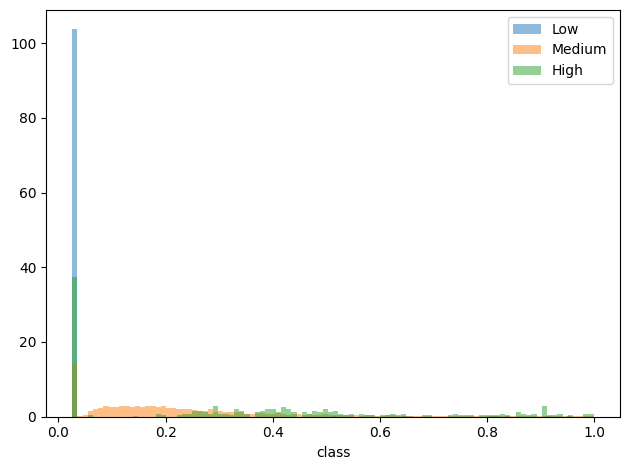

In [150]:
bins=100
alpha=.5
max_x_axes = 1
plt.figure()
lows = [loss for loss, lb in all_losses if lb == 'Low' and loss <= max_x_axes]
meds = [loss for loss, lb in all_losses if lb == 'Medium' and loss <= max_x_axes]
highs = [loss for loss, lb in all_losses if lb == 'High' and loss <= max_x_axes]
#print(len(lows), len(meds), len(highs))
plt.hist(lows, bins = bins, density = True, alpha = alpha, label = 'Low')
plt.hist(meds, bins = bins, density = True, alpha = alpha, label = 'Medium')
plt.hist(highs, bins = bins, density = True, alpha = alpha, label = 'High')
plt.xlabel('class')
plt.legend()
plt.tight_layout()
plt.show()

In [189]:
len([loss for loss, lb in all_losses if lb == 'Medium' if loss >= .047])


7392

In [203]:
mylows = [loss for loss, lb in all_losses if lb == 'Low']
mymeds = [loss for loss, lb in all_losses if lb == 'Medium']
myhighs = [loss for loss, lb in all_losses if lb == 'High']
epsilon = 1e-8
llen = len(mylows)
best_th1 = 0
mylist = list(set(mylows) | set(mymeds) | set(myhighs))
mylist.sort()
for th1 in mylist:
    tps = len([el for el in mylows if el < th1])
    if tps / llen > .89:
        best_th1 = th1
        break
    else:
        best_th1 = th1
best_th1

0.03447301685810089

In [194]:
hlen = len(myhighs)
best_th2 = 0
mylist = list(set(mylows) | set(mymeds) | set(myhighs))
mylist.sort(reverse = True)
for th2 in mylist:
    tps = len([el for el in myhighs if el >= th2])
    if tps / hlen > .65:
        best_th2 = th2 #(best_th2 + th2) / 2
        break
    else:
        best_th2 = th2
best_th2

0.6442042589187622

In [195]:
len([el for el in mymeds if el >= best_th1 and el < best_th2]) / len(mymeds)

0.7515586401599812

In [174]:
threshold1 = 0.045 #best_th1
threshold2 = 0.645 #best_th2
threshold1, threshold2

(0.0344, 0.485)

In [ ]:
# KEEP BATCH SIZE = 1 HERE, PLEASE

all_preds = []
for batch in test_data_loader: #iterating through test ds with step B
    x = batch[0]
    x = x.to(gpu_device_idx)
    preds = ["Low"] * x.shape[2] 
    idx_medium = 0
    flag_medium = False
    
    for i in range(x.shape[2]): #iterating through L
        #right pad
        max_len = config['trainer_params']['input_length']
        x_padded = torch.zeros((x.shape[0], x.shape[1], max_len))
        for j, d in enumerate(x): 
            x_padded[j, :, max_len - i:] = x[j,:,:i]

        recons_loss, vq_losses, perplexities = exp_vqvae.forward((x_padded,))
        
        loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
                recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
                vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
                recons_loss['perceptual']
        
        #mask_low = (recons_loss[recons_loss['LF.timefreq'] > threshold1 or recons_loss['HF.timefreq'] > threshold1])
        #mask_medium = (recons_loss[recons_loss['LF.timefreq'] > threshold2 or recons_loss['HF.timefreq'] > threshold2])
        mask_gt_low = (loss > threshold1)
        mask_gt_medium = (loss > (threshold2 - idx_medium * (threshold2 - threshold1) / x.shape[2]))

        if mask_gt_low:
            idx_medium += 1
        
        if mask_gt_medium:
            if not flag_medium: 
                preds = ["Medium"] * x.shape[2]
                flag_medium = True
            preds[i:] = ["High"] * (x.shape[2] - i) 
             
    all_preds.append(preds)

In [176]:
all_preds

[['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',

In [177]:
df_pred = pd.DataFrame(data=np.ravel(all_preds), columns=['pred'])
df_pred.to_csv(os.path.join(DIR_PATH,'SampleSubmission/prediction.csv'), index=False)